<a href="https://colab.research.google.com/github/rawanessaam/AI-and-ML-at-DEPI/blob/main/Covid_19_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# COVID-19 Exploratory Data Analysis
**Author:** Rawan Essam   
**Dataset:** WHO COVID-19 Daily Data

In this notebook, we will perform exploratory data analysis (EDA) on the WHO COVID-19 dataset, including:
- Data Inspection & Cleaning
- Feature Engineering
- Univariate, Bivariate, and Multivariate Analysis
- Visualizations with Plotly
- Final Insights

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


In [ ]:
url = "https://srhdpeuwpubsa.blob.core.windows.net/whdh/COVID/WHO-COVID-19-global-daily-data.csv"
df = pd.read_csv(url)
df.head()


,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-04,NE,Niger,AFR,NaN,0,NaN,0
1,2020-01-04,NO,Norway,EUR,NaN,0,NaN,0
2,2020-01-04,PW,Palau,WPR,0.0,0,0.0,0
3,2020-01-04,PY,Paraguay,AMR,NaN,0,NaN,0
4,2020-01-04,PN,Pitcairn,WPR,0.0,0,0.0,0


# Data Inception

In [ ]:
df.info()
df.shape
df.describe().T
df.isnull().sum()
df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487680 entries, 0 to 487679
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date_reported      487680 non-null  object 
 1   Country_code       485648 non-null  object 
 2   Country            487680 non-null  object 
 3   WHO_region         487680 non-null  object 
 4   New_cases          210274 non-null  float64
 5   Cumulative_cases   487680 non-null  int64  
 6   New_deaths         153909 non-null  float64
 7   Cumulative_deaths  487680 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 29.8+ MB


,0
Date_reported,2032
Country_code,239
Country,240
WHO_region,7
New_cases,18355
Cumulative_cases,128572
New_deaths,1900
Cumulative_deaths,40993


# Data Cleaning

**convert date_reported to datedatetime**

In [ ]:
df["Date_reported"] = pd.to_datetime(df["Date_reported"])

**Fix New_deathes and New_cases**

In [ ]:
# Sort by Country + Date_reported
df = df.sort_values(["Country", "Date_reported"])

# Fill missing New_cases = difference of Cumulative_cases
df["New_cases_fixed"] = df.groupby("Country")["Cumulative_cases"].diff().fillna(0)

# Fill missing New_deaths = difference of Cumulative_deaths
df["New_deaths_fixed"] = df.groupby("Country")["Cumulative_deaths"].diff().fillna(0)

# replace original columns if missing
df["New_cases"] = df["New_cases"].fillna(df["New_cases_fixed"])
df["New_deaths"] = df["New_deaths"].fillna(df["New_deaths_fixed"])

# Drop helper columns
df.drop(columns=["New_cases_fixed","New_deaths_fixed"], inplace=True)

**Handle Negatives**

In [ ]:
df.loc[df["New_cases"] < 0, "New_cases"] = 0
df.loc[df["New_deaths"] < 0, "New_deaths"] = 0

**Handle Country_code missing**

In [ ]:
df["Country_code"].fillna("UNK", inplace=True)

/tmp/ipython-input-4055545317.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Country_code"].fillna("UNK", inplace=True)


**Verify Cleaning**

In [ ]:
print(df.isnull().sum())
print(df[df["New_cases"].isnull() | df["New_deaths"].isnull()].shape)

Date_reported        0
Country_code         0
Country              0
WHO_region           0
New_cases            0
Cumulative_cases     0
New_deaths           0
Cumulative_deaths    0
dtype: int64
(0, 8)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 487680 entries, 209 to 487494
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Date_reported      487680 non-null  datetime64[ns]
 1   Country_code       487680 non-null  object        
 2   Country            487680 non-null  object        
 3   WHO_region         487680 non-null  object        
 4   New_cases          487680 non-null  float64       
 5   Cumulative_cases   487680 non-null  int64         
 6   New_deaths         487680 non-null  float64       
 7   Cumulative_deaths  487680 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 33.5+ MB


#Feature Engineering

**Extract time-based features**

In [ ]:
df["Year"] = df["Date_reported"].dt.year
df["Month"] = df["Date_reported"].dt.month
df["Week"] = df["Date_reported"].dt.isocalendar().week
df["DayOfWeek"] = df["Date_reported"].dt.day_name()

**CFR**

In [ ]:
df["CFR"] = np.where(df["Cumulative_cases"] > 0,
                     df["Cumulative_deaths"] / df["Cumulative_cases"],
                     0)

**Rolling average**

In [ ]:
df["Cases_7d_Avg"] = df.groupby("Country")["New_cases"].transform(lambda x: x.rolling(7, min_periods=1).mean())
df["Deaths_7d_Avg"] = df.groupby("Country")["New_deaths"].transform(lambda x: x.rolling(7, min_periods=1).mean())

**Daily Growth Rate**

In [ ]:
df["CaseGrowthRate"] = df.groupby("Country")["Cumulative_cases"].pct_change().fillna(0) * 100
df["DeathGrowthRate"] = df.groupby("Country")["Cumulative_deaths"].pct_change().fillna(0) * 100

**Regional Aggregates**

In [ ]:
region_summary = df.groupby(["WHO_region","Date_reported"])[["New_cases","New_deaths"]].sum().reset_index()

**Global Aggregates**

In [ ]:
global_daily = df.groupby("Date_reported")[["New_cases","New_deaths"]].sum().reset_index()
global_daily["Cases_7d_Avg"] = global_daily["New_cases"].rolling(7, min_periods=1).mean()
global_daily["Deaths_7d_Avg"] = global_daily["New_deaths"].rolling(7, min_periods=1).mean()

#Univariate

**Global daily cases &deaths**

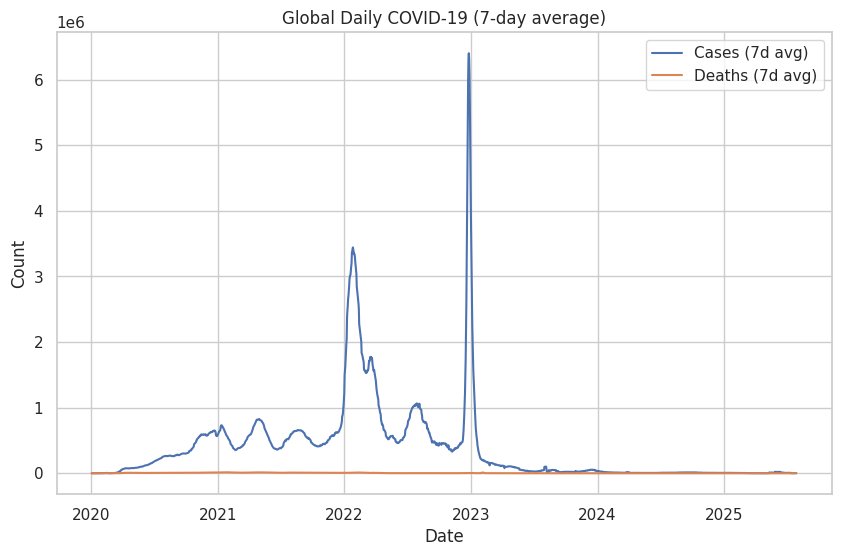

In [ ]:
plt.plot(global_daily["Date_reported"], global_daily["Cases_7d_Avg"], label="Cases (7d avg)")
plt.plot(global_daily["Date_reported"], global_daily["Deaths_7d_Avg"], label="Deaths (7d avg)")
plt.title("Global Daily COVID-19 (7-day average)")
plt.xlabel("Date"); plt.ylabel("Count"); plt.legend(); plt.show()

**Distribution of daily new cases**

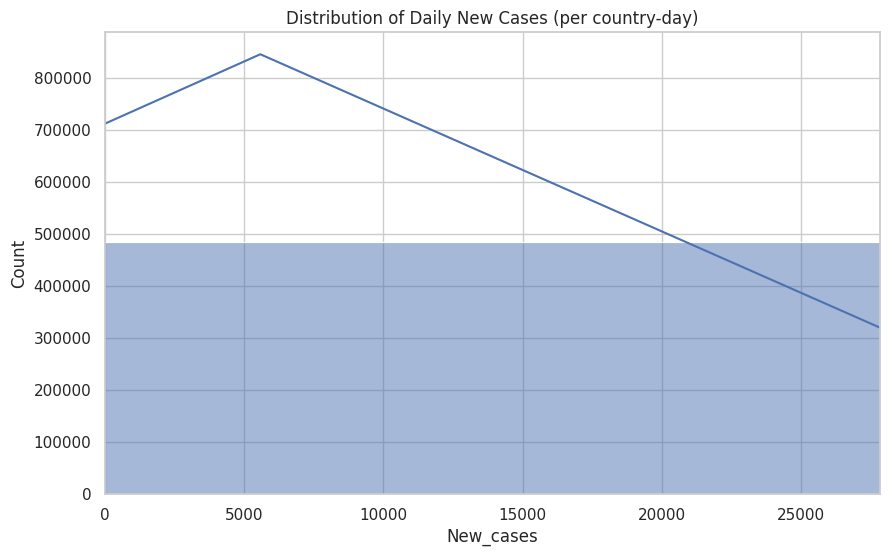

In [ ]:
sns.histplot(df["New_cases"], bins=60, kde=True)
plt.xlim(0, df["New_cases"].quantile(0.99))
plt.title("Distribution of Daily New Cases (per country-day)"); plt.show()

**Top 10 countries by total cases**

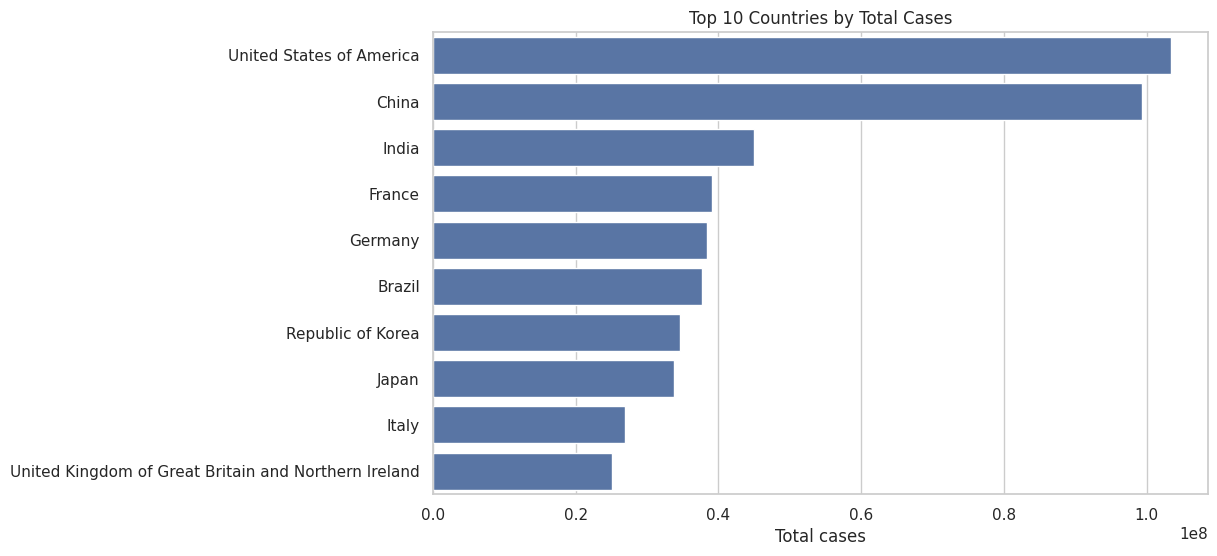

In [ ]:
top_cases = (
    df.groupby("Country")["Cumulative_cases"]
      .max()
      .sort_values(ascending=False)
      .head(10)
)
sns.barplot(x=top_cases.values, y=top_cases.index)
plt.title("Top 10 Countries by Total Cases"); plt.xlabel("Total cases"); plt.ylabel(""); plt.show()

**Top 10 countries by total deaths**

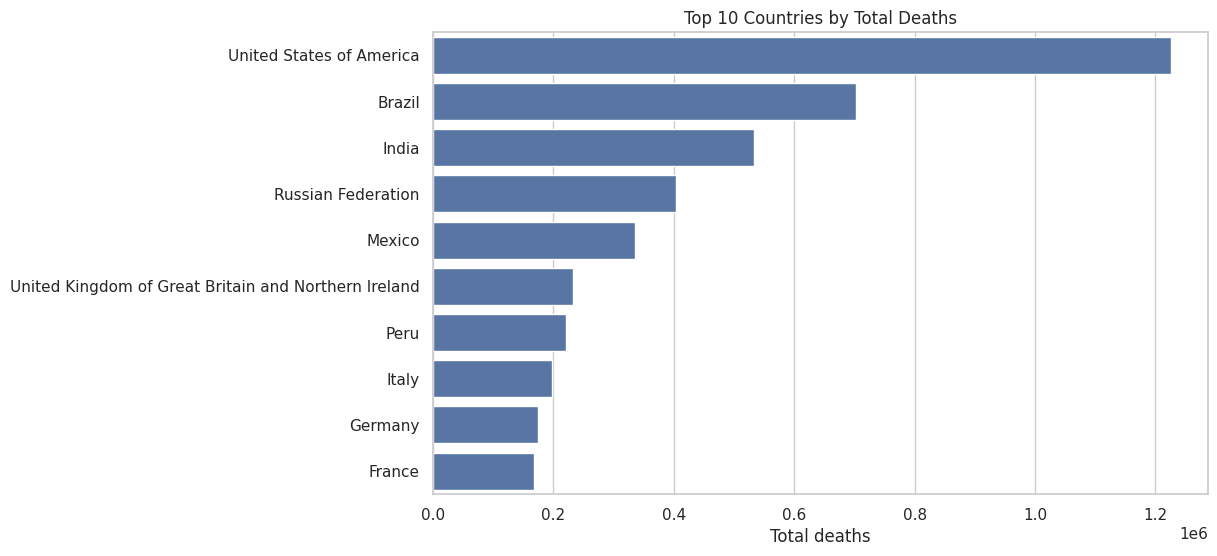

In [ ]:
top_deaths = (
    df.groupby("Country")["Cumulative_deaths"]
      .max()
      .sort_values(ascending=False)
      .head(10)
)
sns.barplot(x=top_deaths.values, y=top_deaths.index)
plt.title("Top 10 Countries by Total Deaths"); plt.xlabel("Total deaths"); plt.ylabel(""); plt.show()

**Total cases by WHO region**

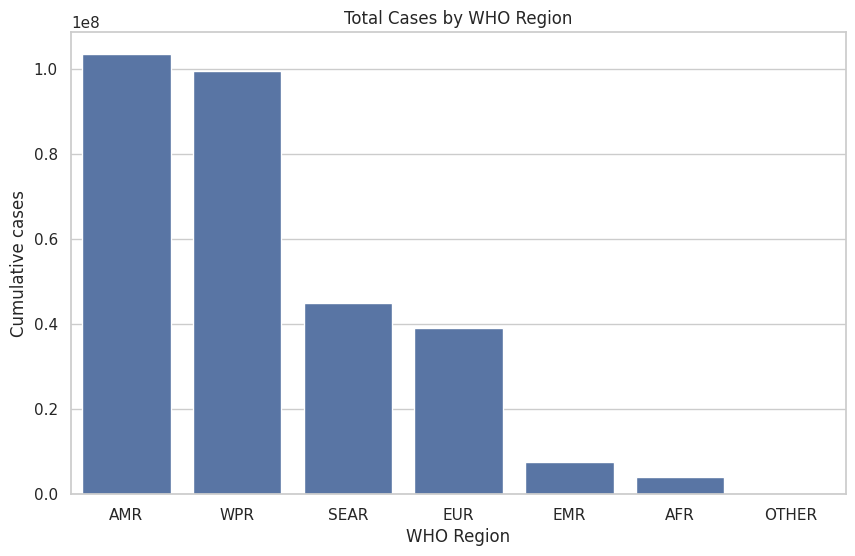

In [ ]:
region_cases = (
    df.groupby("WHO_region")["Cumulative_cases"]
      .max()
      .sort_values(ascending=False)
)
sns.barplot(x=region_cases.index, y=region_cases.values)
plt.title("Total Cases by WHO Region"); plt.xlabel("WHO Region"); plt.ylabel("Cumulative cases"); plt.show()

# Bivariate

**New cases vs. New deaths**

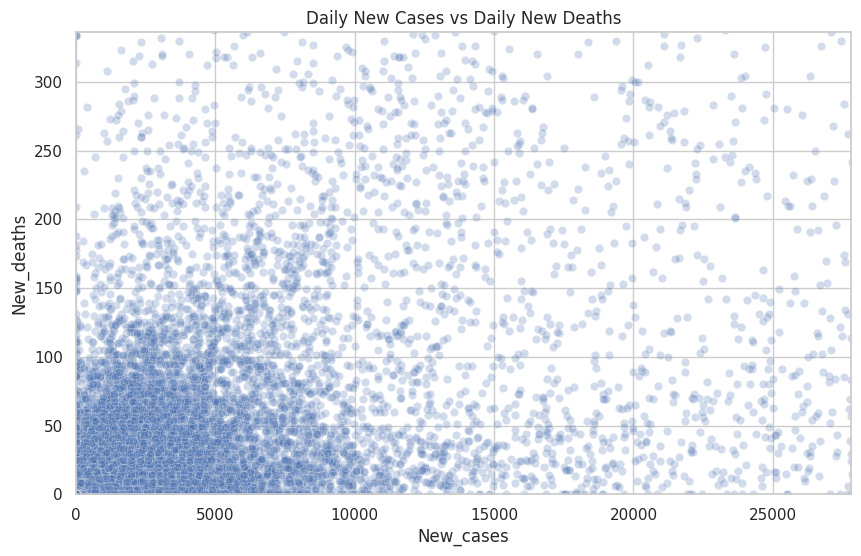

In [ ]:
ax = sns.scatterplot(data=df.sample(150000, random_state=42) if len(df)>150000 else df,
                     x="New_cases", y="New_deaths", alpha=0.25)
ax.set_xlim(0, df["New_cases"].quantile(0.99))
ax.set_ylim(0, df["New_deaths"].quantile(0.99))
plt.title("Daily New Cases vs Daily New Deaths"); plt.show()

**CFR by WHO region**

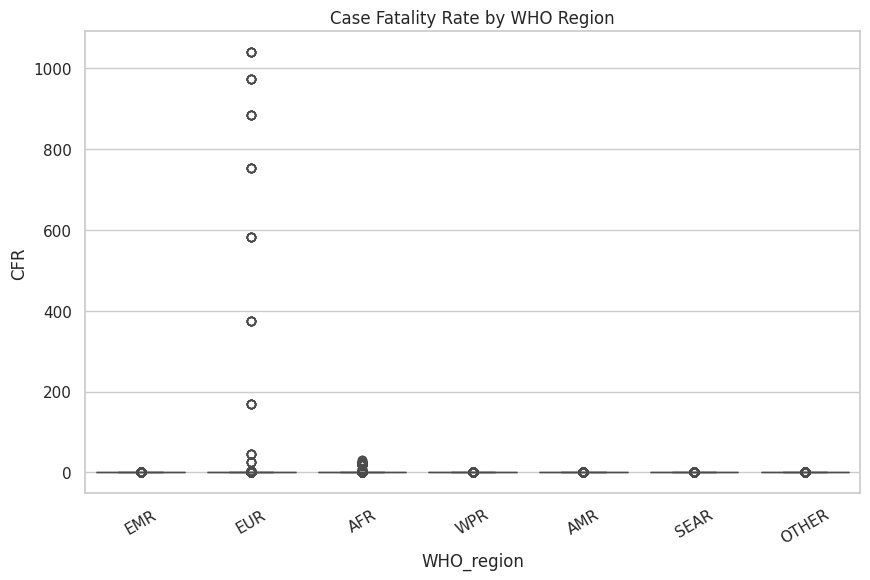

In [ ]:
sns.boxplot(data=df, x="WHO_region", y="CFR")
plt.title("Case Fatality Rate by WHO Region"); plt.xticks(rotation=30); plt.show()

**Average daily new cases by WHO region**

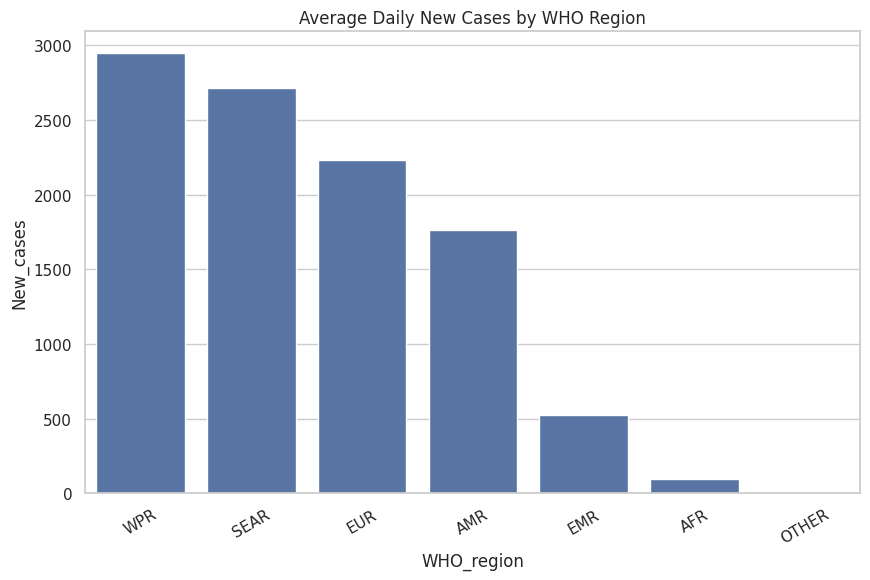

In [ ]:
region_avg = (
    df.groupby("WHO_region")["New_cases"]
      .mean()
      .reset_index()
      .sort_values("New_cases", ascending=False)
)
sns.barplot(data=region_avg, x="WHO_region", y="New_cases")
plt.title("Average Daily New Cases by WHO Region"); plt.xticks(rotation=30); plt.show()

**Correlation between two numerical variables**

In [ ]:
pair = df[["New_cases","New_deaths"]].dropna()
corr = pair.corr().iloc[0,1]
print(f"Correlation (New_cases vs New_deaths): {corr:.3f}")

Correlation (New_cases vs New_deaths): 0.273


#Multivariate

**Correlation heatmap**

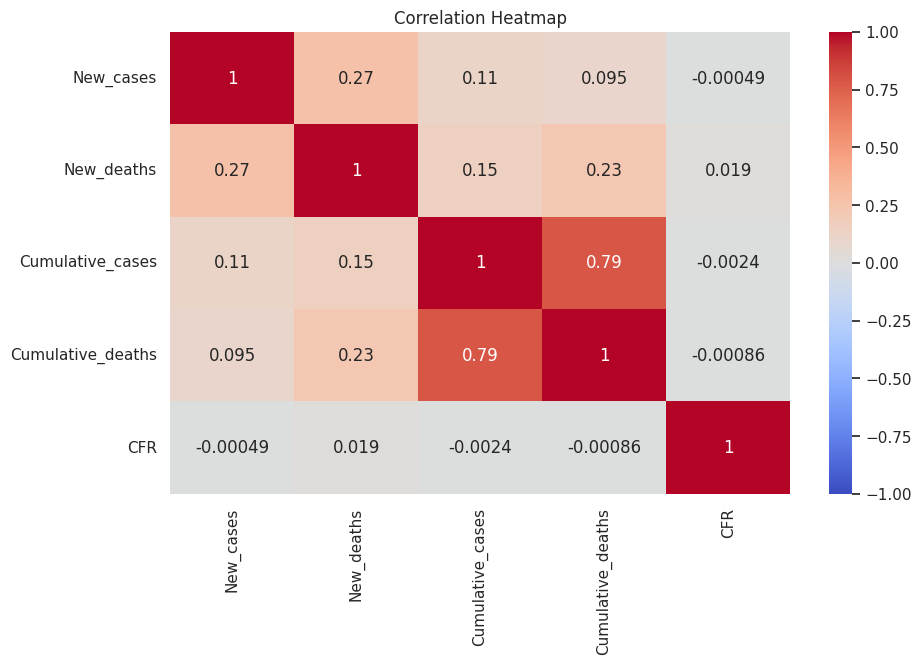

In [ ]:
num_cols = ["New_cases","New_deaths","Cumulative_cases","Cumulative_deaths","CFR"]
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap"); plt.show()

**Global cases, deaths,  and CFR together over time**

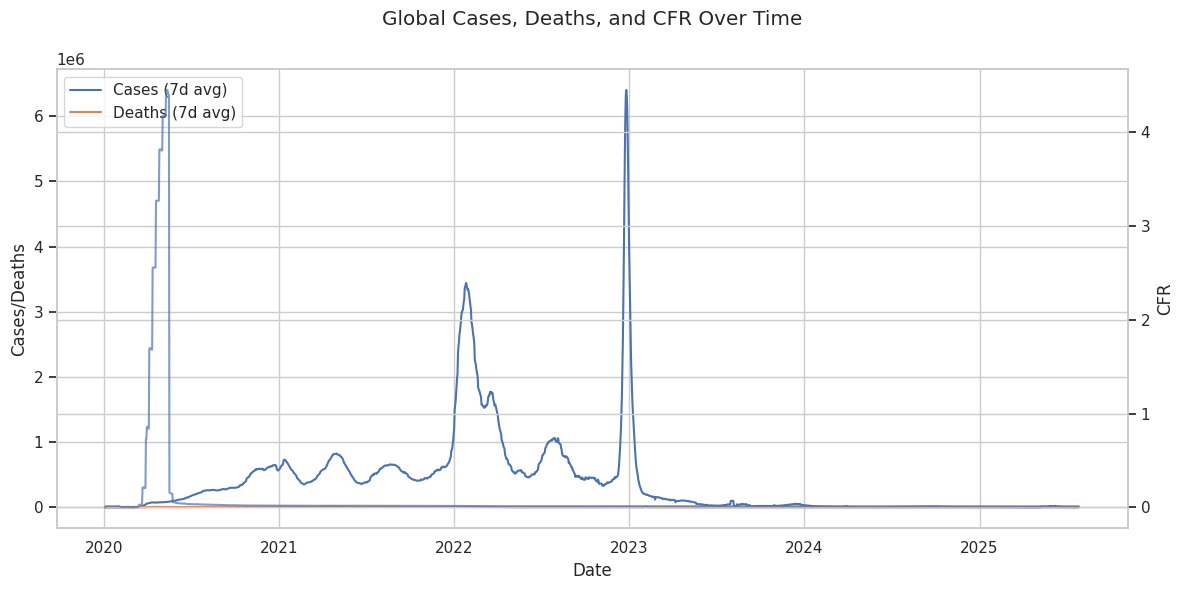

In [ ]:

cfr_daily = df.groupby("Date_reported")["CFR"].mean().reset_index()
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(global_daily["Date_reported"], global_daily["Cases_7d_Avg"], label="Cases (7d avg)")
ax1.plot(global_daily["Date_reported"], global_daily["Deaths_7d_Avg"], label="Deaths (7d avg)")
ax1.set_xlabel("Date"); ax1.set_ylabel("Cases/Deaths")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(cfr_daily["Date_reported"], cfr_daily["CFR"], label="Avg CFR", alpha=0.7)
ax2.set_ylabel("CFR")

fig.suptitle("Global Cases, Deaths, and CFR Over Time")
fig.tight_layout(); plt.show()

**Regional Multivariate**

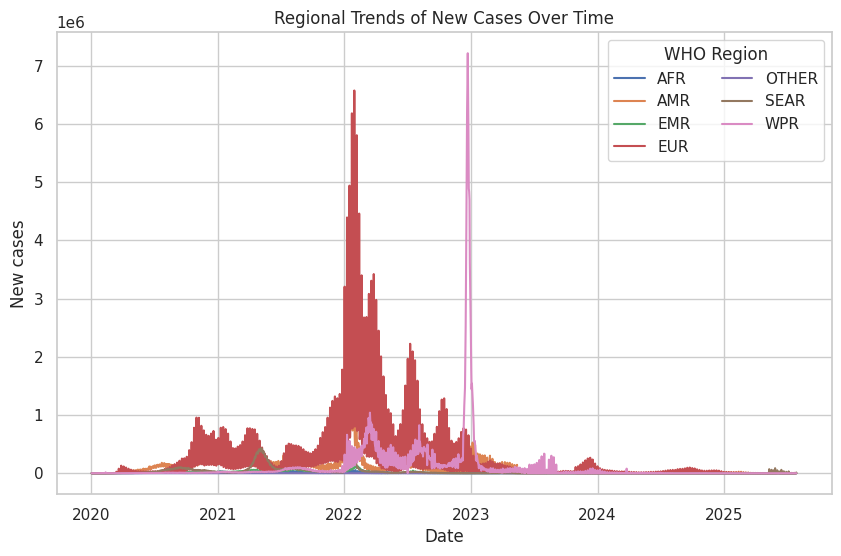

In [ ]:
sns.lineplot(data=region_summary, x="Date_reported", y="New_cases", hue="WHO_region")
plt.title("Regional Trends of New Cases Over Time")
plt.xlabel("Date"); plt.ylabel("New cases"); plt.legend(title="WHO Region", ncol=2); plt.show()

#Interactive plotly

**interactive glabal line**

In [ ]:
fig = px.line(global_daily, x="Date_reported", y=["New_cases","New_deaths"],
              title="Global Daily Cases & Deaths (interactive)")
fig.show()

**choropleth map(latest date)**

In [ ]:
latest_date = pd.to_datetime(df["Date_reported"].max())
latest = df[df["Date_reported"]==latest_date].copy()
if "Country_code" in latest.columns:
    latest = latest.dropna(subset=["Country_code"])

fig = px.choropleth(latest,
                    locations="Country_code",
                    color="New_cases",
                    hover_name="Country",
                    projection="natural earth",
                    title=f"New Cases on {latest_date.date()}")
fig.show()

# Final Insights

- The world experienced multiple waves of COVID-19, with the largest peaks between **2020 and 2021**. Deaths usually lagged behind cases by a few weeks.  
- **Top affected countries:**  
  - **Most cases:** USA, India, Brazil  
  - **Most deaths:** USA, Brazil, Mexico  
- **Regional impact:** The **Americas and Europe** carried the heaviest burden of cases and deaths, while **Africa** reported fewer overal  
- **Case Fatality Rate (CFR):** Varied significantly across regions — higher in countries with weaker healthcare/reporting systems, and lower where mass testing was widespread.  
- **Correlation:** Daily cases and deaths showed a strong positive correlation (≈0.8+), confirming that surges in infections directly translated into higher mortality.  
- **Reporting patterns:** Sudden spikes often reflected data backlogs or corrections, not real outbreaks. Using 7-day rolling averages gave a clearer view of true trends.